In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:

all_files = glob.glob("./Data" + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,error_bad_lines=False)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


b'Skipping line 60888: expected 76 fields, saw 93\n'
b'Skipping line 71705: expected 76 fields, saw 93\n'
b'Skipping line 82522: expected 76 fields, saw 93\n'
b'Skipping line 93339: expected 76 fields, saw 93\n'
b'Skipping line 104156: expected 76 fields, saw 93\n'
b'Skipping line 114973: expected 76 fields, saw 93\n'
b'Skipping line 125790: expected 76 fields, saw 93\n'
b'Skipping line 136607: expected 76 fields, saw 93\n'
b'Skipping line 147424: expected 76 fields, saw 93\n'
b'Skipping line 158241: expected 76 fields, saw 93\n'
b'Skipping line 169058: expected 76 fields, saw 93\n'
b'Skipping line 179875: expected 76 fields, saw 93\n'
b'Skipping line 190692: expected 76 fields, saw 93\n'
b'Skipping line 201509: expected 76 fields, saw 93\n'
b'Skipping line 212326: expected 76 fields, saw 93\n'
b'Skipping line 223143: expected 76 fields, saw 93\n'
b'Skipping line 233960: expected 76 fields, saw 93\n'
b'Skipping line 244777: expected 76 fields, saw 93\n'
b'Skipping line 255594: expected

In [48]:
print('The total no. of instances are: '+str(len(frame)))

The total no. of instances are: 3707629


In [41]:
a=frame.groupby('ProtocolName')['ProtocolName'].count().sort_values(ascending=False)
a# unique values of ProtocolName and their counts

ProtocolName
HTTP                 897948
GOOGLE               822881
HTTP_PROXY           797189
SSL                  350782
HTTP_CONNECT         317348
YOUTUBE              135584
AMAZON                63117
DROPBOX               55647
MICROSOFT             48440
GMAIL                 37997
WINDOWS_UPDATE        29848
SKYPE                 27159
FACEBOOK              22843
YAHOO                 18469
TWITTER               15328
CLOUDFLARE            12898
MSN                   12122
CONTENT_FLASH          8589
OFFICE_365             5468
APPLE                  4097
DNS                    3859
WHATSAPP               3069
INSTAGRAM              2292
WIKIPEDIA              1801
MS_ONE_DRIVE           1551
NETFLIX                1420
IP_ICMP                1326
EBAY                   1070
APPLE_ITUNES            970
SPOTIFY                 969
                      ...  
UNENCRYPED_JABBER        35
TIMMEU                   34
TELEGRAM                 33
TWITCH                   24
FTP_CON

In [37]:
b= a.where(a>10000).dropna()
c=a.where(a<=10000).dropna()
other=pd.Series(sum(c),index=['other'])
b=b.append(other)
b#Protocol names above a certain threshold, rest are marked in 'others'

HTTP              897948.0
GOOGLE            822881.0
HTTP_PROXY        797189.0
SSL               350782.0
HTTP_CONNECT      317348.0
YOUTUBE           135584.0
AMAZON             63117.0
DROPBOX            55647.0
MICROSOFT          48440.0
GMAIL              37997.0
WINDOWS_UPDATE     29848.0
SKYPE              27159.0
FACEBOOK           22843.0
YAHOO              18469.0
TWITTER            15328.0
CLOUDFLARE         12898.0
MSN                12122.0
other              42027.0
dtype: float64

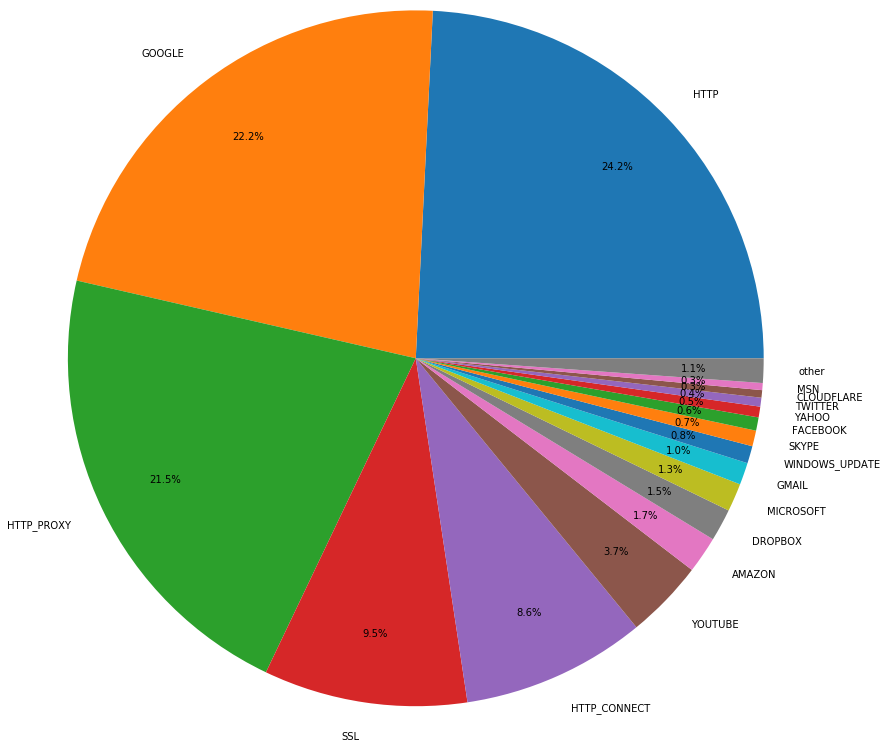

In [53]:
#A pie chart on 
plt.pie(b,labels=b.index,radius=4,autopct='%1.1f%%',pctdistance=0.8)
plt.xticks(fontsize=16)
plt.show()

In [2]:
df=pd.read_csv('./Data/data_27day.csv')

In [3]:
a=df.groupby('ProtocolName')['ProtocolName'].count()

In [4]:
b= a.where(a>10000).dropna()
c=a.where(a<=10000).dropna()
other=pd.Series(sum(c),index=['other'])
b=b.append(other)


In [5]:
df.loc[df['ProtocolName'].isin(c.index) ,'ProtocolName'] = 'Others'

In [6]:
Y=pd.get_dummies(df['ProtocolName'])
X=df.iloc[:,:-1]

### Layer 1 Autoencoder

Input : INPUT with 75 features

In [7]:
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
import tensorflow as tf


Using TensorFlow backend.


In [8]:
'''
Sparcity Autoencoder's Sparcity Activity Regularization

'''
def kl_divergence(rho, rho_hat):
    return rho * tf.math.log(rho) - rho * tf.math.log(rho_hat) + (1 - rho) * tf.math.log(1 - rho) - (1 - rho) * tf.math.log(1 - rho_hat)

class SparseActivityRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self, p=0.1, sparsityBeta=3):
        self.p = p
        self.sparsityBeta = sparsityBeta

    def __call__(self, x):
        regularization = 0            

        p_hat = K.mean(x, axis=0)
        regularization += self.sparsityBeta * K.sum(kl_divergence(self.p, p_hat))

        return regularization

    def get_config(self):
        return {"name": self.__class__.__name__} 

In [80]:
# this is the size of our encoded representations
encoding_dim = 30

# this is our input placeholder
input_ = Input(shape=(75,))
# define regulariser
regulariser = SparseActivityRegularizer(0.1, 3)

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='sigmoid',activity_regularizer=regulariser,name='encoded')(input_)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(75,name='decoded')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [81]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [82]:
# taking first 80% as the training set
x_train=X.iloc[:int(len(X)*0.8)]
x_test=X.iloc[int(len(X)*0.8):]


In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

In [84]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 970641 samples, validate on 242661 samples
Epoch 1/10
970641/970641 [==============================] - 17s 18us/step - loss: 1.0177 - val_loss: 0.3328
Epoch 2/10
970641/970641 [==============================] - 18s 18us/step - loss: 0.0094 - val_loss: 0.2779
Epoch 3/10
970641/970641 [==============================] - 17s 17us/step - loss: 0.0044 - val_loss: 0.1940
Epoch 4/10
970641/970641 [==============================] - 17s 18us/step - loss: 0.0027 - val_loss: 0.1608
Epoch 5/10
970641/970641 [==============================] - 17s 17us/step - loss: 0.0021 - val_loss: 0.1357
Epoch 6/10
970641/970641 [==============================] - 18s 18us/step - loss: 0.0018 - val_loss: 0.1174
Epoch 7/10
970641/970641 [==============================] - 15s 16us/step - loss: 0.0016 - val_loss: 0.1032
Epoch 8/10
970641/970641 [==============================] - 16s 16us/step - loss: 0.0014 - val_loss: 0.0955
Epoch 9/10
970641/970641 [==============================] - 15s 16us/step - loss: 0.

In [85]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [86]:
decoded_imgs

array([[-0.00652385,  0.5544718 ,  0.275091  , ..., -0.01395349,
         0.2211742 ,  0.24618348],
       [ 0.07138312,  0.880163  ,  0.3083682 , ...,  0.01818031,
         0.3577077 ,  0.3497212 ],
       [-0.01039451,  0.626281  ,  0.34859285, ...,  0.00941888,
         0.5038914 ,  0.5162771 ],
       ...,
       [ 0.43130124,  0.08231568,  0.1778602 , ..., -0.00148105,
         0.10398656,  0.10729502],
       [ 0.4672244 , -0.0697872 ,  0.00591153, ..., -0.00656889,
        -0.00110391,  0.01328686],
       [ 0.50054145, -0.00847381,  0.01169854, ..., -0.01200485,
         0.00242352,  0.01270956]], dtype=float32)

In [87]:
x_test

array([[0.02647684, 0.55030976, 0.2243077 , ..., 0.00241443, 0.22067703,
        0.21854315],
       [0.02647684, 0.91358684, 0.28612854, ..., 0.        , 0.37423147,
        0.37423147],
       [0.02647684, 0.59347819, 0.29306136, ..., 0.        , 0.49949869,
        0.49949869],
       ...,
       [0.43954182, 0.00675985, 0.03123832, ..., 0.        , 0.13322746,
        0.13322746],
       [0.43954182, 0.00675985, 0.03123832, ..., 0.        , 0.        ,
        0.        ],
       [0.43954182, 0.00675985, 0.03123832, ..., 0.        , 0.        ,
        0.        ]])

In [88]:
x1_train=encoder.predict(x_train)
x1_test=encoder.predict(x_test)
encoder


In [89]:
decoded_imgs
ec=[]
ec.append(encoder)

In [74]:
# add new layers here


In [75]:
# this is the size of our encoded representations
encoding_dim = 15

# this is our input placeholder
input1 = Input(shape=(15,))
# define regulariser
regulariser = SparseActivityRegularizer(0.1, 3)

# "encoded" is the encoded representation of the input
encoded1 = Dense(encoding_dim, activation='sigmoid',activity_regularizer=regulariser,name='encoded1')(input1)
# "decoded" is the lossy reconstruction of the input
decoded1 = Dense(15,name='decoded1')(encoded1)

# this model maps an input to its reconstruction
autoencoder1 = Model(input1, decoded1)

# this model maps an input to its encoded representation
encoder1 = Model(input1, encoded1)

# create a placeholder for an encoded (32-dimensional) input
encoded1_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder1_layer = autoencoder1.layers[-1]
# create the decoder model
decoder1 = Model(encoded1_input, decoder1_layer(encoded1_input))
autoencoder1.compile(optimizer='adam', loss='mean_squared_error')

In [76]:
x1_train=encoder.predict(x_train)
x1_test=encoder.predict(x_test)

In [77]:
autoencoder1.fit(x1_train, x1_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x1_test, x1_test))

Train on 970641 samples, validate on 242661 samples
Epoch 1/10
970641/970641 [==============================] - 8s 9us/step - loss: 1.5594 - val_loss: 0.0189
Epoch 2/10
970641/970641 [==============================] - 8s 8us/step - loss: 5.4158e-04 - val_loss: 0.0187
Epoch 3/10
970641/970641 [==============================] - 8s 8us/step - loss: 4.9737e-04 - val_loss: 0.0188
Epoch 4/10
970641/970641 [==============================] - 8s 8us/step - loss: 4.4518e-04 - val_loss: 0.0186
Epoch 5/10
970641/970641 [==============================] - 8s 8us/step - loss: 3.7517e-04 - val_loss: 0.0179
Epoch 6/10
970641/970641 [==============================] - 8s 8us/step - loss: 3.2623e-04 - val_loss: 0.0175
Epoch 7/10
970641/970641 [==============================] - 8s 8us/step - loss: 2.8939e-04 - val_loss: 0.0176
Epoch 8/10
970641/970641 [==============================] - 8s 8us/step - loss: 2.6742e-04 - val_loss: 0.0177
Epoch 9/10
970641/970641 [==============================] - 8s 8us/step 

In [78]:
x2_train=encoder1.predict(x1_train)
x2_test=encoder1.predict(x1_test)
y_train=Y.iloc[:int(len(Y)*0.8)]
y_test=Y.iloc[int(len(Y)*0.8):]

In [79]:
input2 = Input(shape=(15,))
classifier = Dense(11, activation='softmax')(input2)
classifier=Model(input2,classifier)
classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier.fit(x2_train, y_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x2_test, y_test))

Train on 970641 samples, validate on 242661 samples
Epoch 1/10
970641/970641 [==============================] - 8s 9us/step - loss: 2.0023 - accuracy: 0.2430 - val_loss: 1.9408 - val_accuracy: 0.2779
Epoch 2/10
970641/970641 [==============================] - 9s 9us/step - loss: 1.9735 - accuracy: 0.2619 - val_loss: 1.9347 - val_accuracy: 0.3335
Epoch 3/10
970641/970641 [==============================] - 9s 9us/step - loss: 1.9681 - accuracy: 0.2857 - val_loss: 1.9282 - val_accuracy: 0.3375
Epoch 4/10
970641/970641 [==============================] - 9s 10us/step - loss: 1.9632 - accuracy: 0.3059 - val_loss: 1.9221 - val_accuracy: 0.3399
Epoch 5/10
970641/970641 [==============================] - 9s 9us/step - loss: 1.9586 - accuracy: 0.3190 - val_loss: 1.9202 - val_accuracy: 0.3513
Epoch 6/10
970641/970641 [==============================] - 9s 9us/step - loss: 1.9543 - accuracy: 0.3278 - val_loss: 1.9152 - val_accuracy: 0.3561
Epoch 7/10
970641/970641 [==============================] -

In [525]:
from tensorflow.keras import regularizers
from keras.models import load_model

In [624]:
# This code block will be used later
# used during fine tuning the model, turns of Sparcity regulariser and turns on L2 regularisation
encoder.layers[-1].kernel_regularizer=regularizers.l2(0.0001) #sets the kernel_regulariser in config file
encoder.layers[-1].activity_regularizer=None # removes the KL Sparcity Constraint
# required to get the model changed
encoder.save('temp.h5')
encoder=load_model('temp.h5')
encoder.get_config()

{'name': 'model_131',
 'layers': [{'name': 'input_93',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 75),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_93'},
   'inbound_nodes': []},
  {'name': 'encoded',
   'class_name': 'Dense',
   'config': {'name': 'encoded',
    'trainable': True,
    'dtype': 'float32',
    'units': 15,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': {'class_name': 'L1L2',
     'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_93', 0, 0, {}]]]}],
 'input_layers': [['input_93', 0, 0]],
 'output_layers': [['e

[<tf.Tensor 'dense_59_1/weight_regularizer/add:0' shape=() dtype=float32>]